In [118]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.sampler import SequentialSampler
from torch.utils.data import Dataset
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate

import matplotlib.colors as mcolors
from matplotlib import rcParams

import os
#-----
from torch.utils.tensorboard import SummaryWriter

# Enable interactive plot
%matplotlib notebook
#plt.style.use('seaborn')

In [2]:
from matplotlib import rc

rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Palatino']})

color1 = ['#ff595e','#ffca3a','#8ac926','#1982c4','#6a4c93']
color = ['#83b692','#f9ada0', '#f9627d', '#c65b7c', '#5b3758']

## Loading dataset

In [3]:
class Propagator_Dataset(Dataset):
    
    def __init__(self, data, targets, sequence_len, total_data = 4700*200, transform=True, traj=200):
        
        self.data = data
        self.targets = targets
        self.transform = transform
        self.sequence_len = sequence_len
        self.total_data = total_data//sequence_len
        self.traj = traj
        
        self.denom = self.traj//self.sequence_len  # 0-199=200 data per file / 5 = seq len 
        
    def __getitem__(self, index):
        
        total_data = self.total_data  # 200 data by file (from 0 to 199), 1000 files(from 0 to 999), total data: 200*100 = 200000
        
        if index > total_data:
            print("Error, this data does not exist")
        else:
            index_data = index#(index//self.denom)%self.denom  # because there 0-199=200 data per file / 5 = seq len 
            #index_t = (index*self.sequence_len-self.traj)%self.traj
            
            X = np.empty((self.sequence_len,96), np.float32)
            y = np.empty((self.sequence_len,64), np.float32)
            
            for i in range(self.sequence_len):
                # Input data: Wavepacket real and imaginary part + Potential at time t
                x_r = (np.load(self.data+str(index_data)+'/Wavepacket/'+str(i)+'-wave.npy')).real
                x_i = (np.load(self.data+str(index_data)+'/Wavepacket/'+str(i)+'-wave.npy')).imag
                x_p = np.load(self.data+str(index_data)+'/Potential/'+str(i)+'-potential.npy')
                
                X[i] = np.concatenate((x_r, x_i, x_p))  # flat array form
                
                # Output data: Wavepacket real and imaginary part at time t+1
                y_r = (np.load(self.targets+str(index_data)+'/Wavepacket/'+str(i+1)+'-wave.npy')).real
                y_i = (np.load(self.targets+str(index_data)+'/Wavepacket/'+str(i+1)+'-wave.npy')).imag
        
                y[i] = np.concatenate((y_r, y_i))  # flat array form
                
            '''  
            # Output data: Wavepacket real and imaginary part at time t+sequence len
            y_r = (np.load(self.targets+str(index_data)+'/Wavepacket/'+str(index_t+self.sequence_len)+'-wave.npy')).real
            y_i = (np.load(self.targets+str(index_data)+'/Wavepacket/'+str(index_t+self.sequence_len)+'-wave.npy')).imag
        
            y = np.concatenate((y_r, y_i))  # flat array form
            '''  
        
            if self.transform:
                X = torch.from_numpy(X)
                y = torch.from_numpy(y)
        
            return X, y#[None, :]
    
    def __len__(self):
        
        
        return self.total_data

In [4]:
path = '../../Data_Gaussian/data'  # Directory where are saving our data
seq_len = 200  # How many time stamps

![Ejemplo](img/example_seq_len.png)


In [5]:
dataset = Propagator_Dataset(data=path, targets=path, transform=True, sequence_len=seq_len)

In [6]:
dataset_size = len(dataset)
print('Total of data ', dataset_size)

Total of data  4700


## Training and Validation data split

In [7]:
test_split = 0.1
validation_split = 0.2  
shuffle_dataset = False
random_seed= 42

In [8]:
# Creating data indices for training and validation splits:
indices = list(range(dataset_size))
split_val = int(np.floor(validation_split * dataset_size))
split_test = int(np.floor(test_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    

test_indices = indices[0:split_test] 
val_indices = indices[split_test:split_test+split_val]   
train_indices = indices[split_test+split_val:]

#train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)


# Creating PT data samplers and loaders: Sequential form:
#train_sampler = SequentialSampler(train_indices)
#test_sampler = SequentialSampler(val_indices)

In [9]:
print(f"Total of train samples: {len(train_sampler)}")
print(f"Total of validation samples: {len(val_sampler)}")
print(f"Total of test samples: {len(test_sampler)}")

Total of train samples: 3290
Total of validation samples: 940
Total of test samples: 470


In [10]:
batch_size = 10

In [11]:
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

## Shape of data

In [211]:
for X, y in train_loader:
    print("Train data:")
    print(f"Shape of X in train loader: {X.shape}")
    print(f"Shape of y in train loader: {y.shape}")
    print(f"Batch size: {X.size(0)}")
    break

Train data:
Shape of X in train loader: torch.Size([10, 200, 96])
Shape of y in train loader: torch.Size([10, 200, 64])
Batch size: 10


## Visualization

In [230]:
# Display features and label.
train_features, train_labels = next(iter(train_loader))

X_vis = train_features[0].squeeze()
y_vis = train_labels[0].squeeze()

<IPython.core.display.Javascript object>


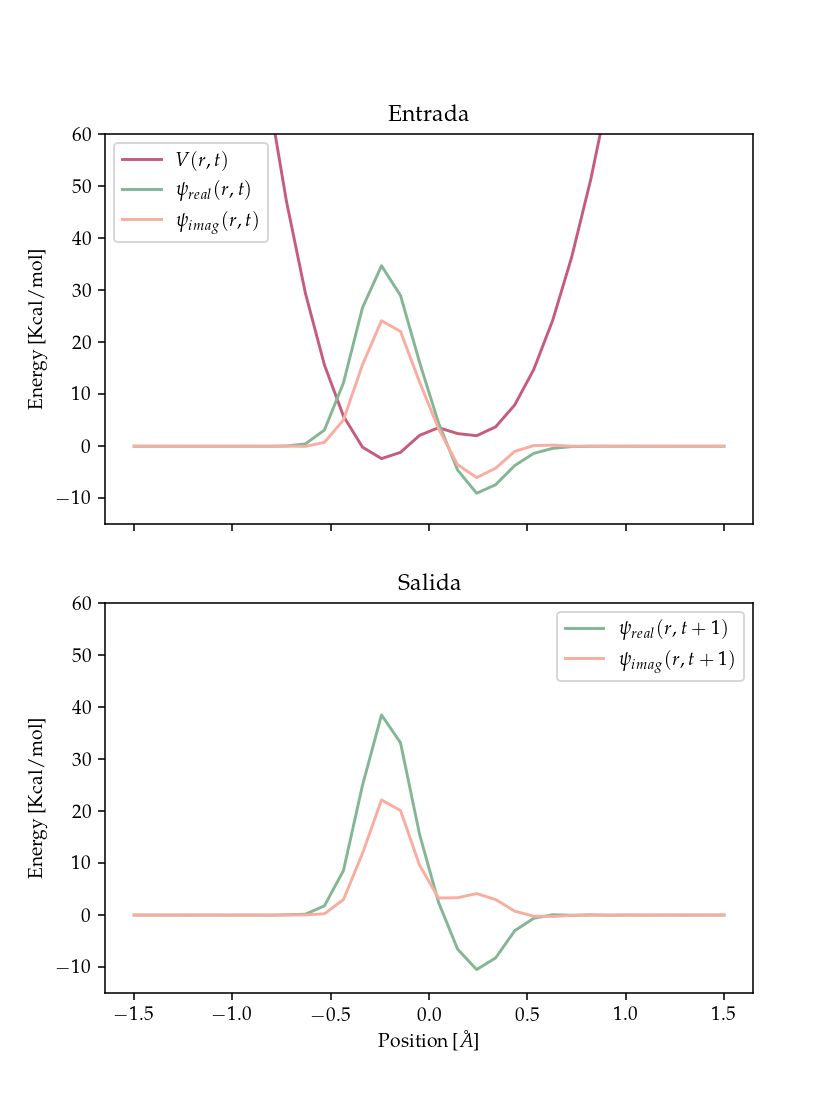

In [231]:
r_n = np.linspace(-1.5,1.5,32)
time = int(100)  # from 0 to 199

In_real_vis = X_vis[time,0:32].detach().numpy()
In_imag_vis = X_vis[time,32:64].detach().numpy()
In_pote = X_vis[time,64:96].detach().numpy()

Ou_real_vis = y_vis[time,0:32].detach().numpy()
Ou_imag_vis = y_vis[time,32:64].detach().numpy()


fig, axs = plt.subplots(2,1)

# Lenght: au -> Angstroms
axs[0].plot(r_n, In_pote*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
axs[0].plot(r_n, In_real_vis*30, label="$\psi_{real}(r, t)$", color = color[0])  # Escaled
axs[0].plot(r_n, In_imag_vis*30, label="$\psi_{imag}(r, t)$", color=color[1])  # Escaled
axs[0].set_title("Entrada")

axs[1].plot(r_n, Ou_real_vis*30, label="$\psi_{real}(r, t+1)$", color = color[0])  # Escaled
axs[1].plot(r_n, Ou_imag_vis*30, label="$\psi_{imag}(r, t+1)$", color = color[1])  # Escaled
axs[1].set_title("Salida")

for axr1 in axs:
    axr1.set_ylim([-15, 60])
    axr1.legend()
    axr1.set(xlabel='Position [$\AA$]', ylabel='Energy [Kcal/mol]')
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.gcf().set_size_inches(6, 8)
ax.legend()
plt.show()

## LSTM model
___

In [15]:
device = 'cpu'

In [16]:
class LSTM(nn.Module):
    def __init__(self, num_output, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_output = num_output  # number of output
        self.num_layers = num_layers  # number of layers
        self.input_size = input_size  # input size
        self.hidden_size = hidden_size  # hidden state
        self.seq_length = seq_length  # sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        
        #self.fc_1 =  nn.Linear(hidden_size, 1024) #fully connected 1

        #self.relu = nn.ReLU()
        
        self.fc = nn.Linear(hidden_size, num_output) #fully connected last layer
    
    def forward(self,x):
        
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        #hn = hn.view(-1,self.hidden_size) #reshaping the data for Dense layer next
        #out = self.relu(hn)
        #out = self.fc_1(out) #first Dense
        #out = self.relu(output) #relu
        out = self.fc(output) #Final Output
        return out

In [18]:
input_size = 96  # number of features: 32 real part +32 complex part +32 potential
hidden_size = 1024  # number of features in hidden state
num_layers = 2  # number of stacked lstm layers

num_output = 64  # number of output: 32 real part + 32 complex part
sequence_len = seq_len # lenght of time steps (1 fs each one) total 5 fs

learning_rate = 1e-4

In [19]:
model = LSTM(num_output, input_size, hidden_size, num_layers, sequence_len) #our lstm class

In [20]:
# Initialize the loss function and optimizer
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)  #weight_decay=0.01 <- default

In [21]:
print(model)

LSTM(
  (lstm): LSTM(96, 1024, num_layers=2, batch_first=True)
  (fc): Linear(in_features=1024, out_features=64, bias=True)
)


## Accuracy function

In [22]:
def S_overlap(Psi_true, Psi_ANN):
    """
    Input:
    Psi_true: Evolution of wavepacket from dataset test, Shape: (batch size, sequence lenght, 64)
    Psi_ANN: Evolution of wavepacket predicted with the model, Shape: (batch size, sequence lenght, 64)
    
    Output:
    S: Absolute magnitude
    angle: phase
    Characterizes the quality of the predictions. See equation (11) of Main article
    
    """
    S_tot = []
    angle_tot = []
    for j in range(batch_size):
        for l in range(seq_len):
            Psi_true_re = Psi_true[j,l,0:32]  # real part of wavepacket
            Psi_true_im = Psi_true[j,l,32:64]  # imaginary part of wavepacket
            Psi_t = torch.view_as_complex(torch.stack((Psi_true_re,Psi_true_im), -1))
    
    
            Psi_ANN_re = Psi_ANN[j,l,0:32]  # realpart of wavepacket predicted
            Psi_ANN_im = -Psi_ANN[j,l,32:64]  # imaginary part of wavepacket predicted (- because conjugate)
            Psi_A = torch.view_as_complex(torch.stack((Psi_ANN_re,Psi_ANN_im), -1))
        
        
        
            overlap = []
            for i in range(32):
                overlap.append(torch.tensor([Psi_A[i]*Psi_t[i]]))
            overl = torch.tensor(overlap)
        
            # Integrate over r (real integral + complex integral)
            # Simpson method in the grid r_n (angstroms -> au)
            r_n = np.linspace(-1.5,1.5,32)*(1/0.5291775)
            overl_real = overl.real.numpy()
            overl_imag = overl.imag.numpy()
    
            real_integ = integrate.simpson(overl_real, r_n)
            imag_integ = integrate.simpson(overl_imag, r_n)
    
            # Covert to phase and magnitude of the complex result
            S_tot.append(np.sqrt(real_integ**2 + imag_integ**2))
            angle_tot.append(np.arctan(imag_integ/real_integ))
        
    S = sum(S_tot)/(batch_size*seq_len)
    angle = sum(angle_tot)/(batch_size*seq_len)
    
    return S, angle

In [ ]:
# Test over test loader
correct1 = 0
for X, y in test_loader:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
    X, y = X.to(device), y.to(device)
    S, angle = S_overlap(y, y)  # Accuracy by equation (11) Main Article       
    correct1 += S
correct1 /= len(test_loader)
print(f"Test Error: \n Accuracy: {(100*correct1):>0.1f}%\n")  # Should be 100% because y=y => main of |S| = 1

In [23]:
writer = SummaryWriter(comment="Update2LSTM_1024neu_seq200_BATCH_10_LR_1E-4_4700DATA")  # To use tensorboard

In [24]:
for X,y in train_loader:
    writer.add_graph(model,X)  # to draw diagram model
    break

## Train & Test loop definition

In [25]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader)#len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.squeeze().to(device)

        # Compute prediction error
        pred = model(X.float()).squeeze()
        loss = loss_fn(pred, y.float())
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    writer.add_scalar("Loss/train", loss.item(), epoch)


In [26]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correctS, correct_phase = 0, 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
            X, y = X.to(device), y.to(device)
            pred = model(X.float())
            test_loss += loss_fn(pred, y).item()
            S, angle = S_overlap(y, pred)  
            correctS += S
            correct_phase += angle
    
    correctS /= num_batches
    correct_phase /= num_batches
    test_loss /= num_batches
    
    writer.add_scalar('Accuracy Magnitude |S| /test', 100*correctS, epoch)  # Should be 100%
    writer.add_scalar('Accuracy phase /test', correct_phase, epoch)  # Should be 0
    writer.add_scalar("Loss/validation", test_loss, epoch)

    

    print(f"Test Error: \n Accuracy Magnitude |S|: {(100*correctS):>0.1f}%")
    print(f"Test Error: \n Accuracy phase: {(correct_phase):>0.1f}\n")

## Training

In [27]:
epochs = 10
for epoch in range(0,epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_loader, model, criterion, optimizer)
    test(val_loader, model, criterion)
    
writer.flush()

Epoch 1
-------------------------------
loss: 0.085931  [    0/  329]
loss: 0.066401  [  100/  329]
loss: 0.061315  [  200/  329]
loss: 0.060639  [  300/  329]
Test Error: 
 Accuracy Magnitude |S|: 29.7%
Test Error: 
 Accuracy phase: -0.0

Epoch 2
-------------------------------
loss: 0.070817  [    0/  329]
loss: 0.061622  [  100/  329]
loss: 0.062393  [  200/  329]
loss: 0.044041  [  300/  329]
Test Error: 
 Accuracy Magnitude |S|: 38.8%
Test Error: 
 Accuracy phase: -0.1

Epoch 3
-------------------------------
loss: 0.052191  [    0/  329]
loss: 0.058054  [  100/  329]
loss: 0.049862  [  200/  329]
loss: 0.048577  [  300/  329]
Test Error: 
 Accuracy Magnitude |S|: 40.5%
Test Error: 
 Accuracy phase: -0.1

Epoch 4
-------------------------------
loss: 0.056448  [    0/  329]
loss: 0.041924  [  100/  329]
loss: 0.044419  [  200/  329]
loss: 0.048639  [  300/  329]
Test Error: 
 Accuracy Magnitude |S|: 39.6%
Test Error: 
 Accuracy phase: 0.0

Epoch 5
-------------------------------
l

In [31]:
epochs = 70
for epoch in range(45,epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_loader, model, criterion, optimizer)
    test(val_loader, model, criterion)
    
writer.flush()

Epoch 46
-------------------------------
loss: 0.009446  [    0/  329]
loss: 0.008735  [  100/  329]
loss: 0.011984  [  200/  329]
loss: 0.011006  [  300/  329]
Test Error: 
 Accuracy Magnitude |S|: 84.7%
Test Error: 
 Accuracy phase: -0.0

Epoch 47
-------------------------------
loss: 0.007370  [    0/  329]
loss: 0.013002  [  100/  329]
loss: 0.013530  [  200/  329]
loss: 0.005507  [  300/  329]
Test Error: 
 Accuracy Magnitude |S|: 84.6%
Test Error: 
 Accuracy phase: -0.0

Epoch 48
-------------------------------
loss: 0.006598  [    0/  329]
loss: 0.007907  [  100/  329]
loss: 0.007135  [  200/  329]
loss: 0.020924  [  300/  329]
Test Error: 
 Accuracy Magnitude |S|: 85.1%
Test Error: 
 Accuracy phase: -0.0

Epoch 49
-------------------------------
loss: 0.005487  [    0/  329]
loss: 0.009645  [  100/  329]
loss: 0.010378  [  200/  329]
loss: 0.011693  [  300/  329]
Test Error: 
 Accuracy Magnitude |S|: 85.4%
Test Error: 
 Accuracy phase: -0.0

Epoch 50
---------------------------

In [32]:
epochs = 90
for epoch in range(70,epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_loader, model, criterion, optimizer)
    test(val_loader, model, criterion)
    
writer.flush()

Epoch 71
-------------------------------
loss: 0.009789  [    0/  329]
loss: 0.010103  [  100/  329]
loss: 0.007596  [  200/  329]
loss: 0.013270  [  300/  329]
Test Error: 
 Accuracy Magnitude |S|: 87.8%
Test Error: 
 Accuracy phase: -0.0

Epoch 72
-------------------------------
loss: 0.015060  [    0/  329]
loss: 0.005716  [  100/  329]
loss: 0.005443  [  200/  329]
loss: 0.016190  [  300/  329]
Test Error: 
 Accuracy Magnitude |S|: 87.9%
Test Error: 
 Accuracy phase: 0.0

Epoch 73
-------------------------------
loss: 0.007436  [    0/  329]
loss: 0.005091  [  100/  329]
loss: 0.005851  [  200/  329]
loss: 0.013131  [  300/  329]
Test Error: 
 Accuracy Magnitude |S|: 87.9%
Test Error: 
 Accuracy phase: 0.0

Epoch 74
-------------------------------
loss: 0.014908  [    0/  329]
loss: 0.009608  [  100/  329]
loss: 0.007407  [  200/  329]
loss: 0.013939  [  300/  329]
Test Error: 
 Accuracy Magnitude |S|: 87.5%
Test Error: 
 Accuracy phase: 0.0

Epoch 75
------------------------------

In [33]:
torch.save(model, './4700Data_LSTM_MODEL2/17-05-23_90EPOCHS.pth')

In [ ]:
model = torch.load('4700Data_LSTM_MODELS/12-05-23_20EPOCHS.pth')

## Accuracy Test New Data

In [34]:
def test1(dataloader, model, loss_fn):
    '''
    Same as test function but without writer to tensorboard
    '''
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correctS, correct_phase = 0, 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
            X, y = X.to(device), y.to(device)
            pred = model(X.float())
            test_loss += loss_fn(pred, y).item()
            S, angle = S_overlap(y,pred)  
            correctS += S
            correct_phase += angle
    
    correctS /= num_batches
    correct_phase /= num_batches

    print(f"Test Error: \n Accuracy Magnitude |S|: {(100*correctS):>0.1f}%")
    print(f"Test Error: \n Accuracy phase: {(correct_phase):>0.1f}\n")

In [290]:
test1(test_loader, model, criterion)

Test Error: 
 Accuracy Magnitude |S|: 88.0%
Test Error: 
 Accuracy phase: 0.0



|Model Name: 17-05-23_90EPOCHS.pth|
|--- |

|Epoch | Accuracy Magnitude | Accuracy phase |
| --- | --- | --- |
|90 | 88.0%| 0.0147 |

## Predictions wavepackets

In [291]:
for X,y in test_loader:
    X, y = X.to(device), y.to(device)
    
    Entrada = X
    
    Salida = y
    with torch.inference_mode():
        Prediccion = model(X.float())
    break

In [292]:
print(Entrada.shape)
print(Prediccion.shape)
print(Salida.shape)

torch.Size([10, 200, 96])
torch.Size([10, 200, 64])
torch.Size([10, 200, 64])


In [293]:
r_n = np.linspace(-1.5,1.5,32)

time = int(18)

In_real_vis = Entrada[2,time,0:32].detach().numpy()
In_imag_vis = Entrada[2,time,32:64].detach().numpy()
Pote = Entrada[2,time,64:96].detach().numpy()

Ou_real_vis = Salida[2,time,0:32].detach().numpy()
Ou_imag_vis = Salida[2,time,32:64].detach().numpy()
Pote_next = Entrada[2,time+1,64:96].detach().numpy()

Pred_real_vis = Prediccion[2,time,0:32].detach().numpy()
Pred_imag_vis = Prediccion[2,time,32:64].detach().numpy()

<IPython.core.display.Javascript object>


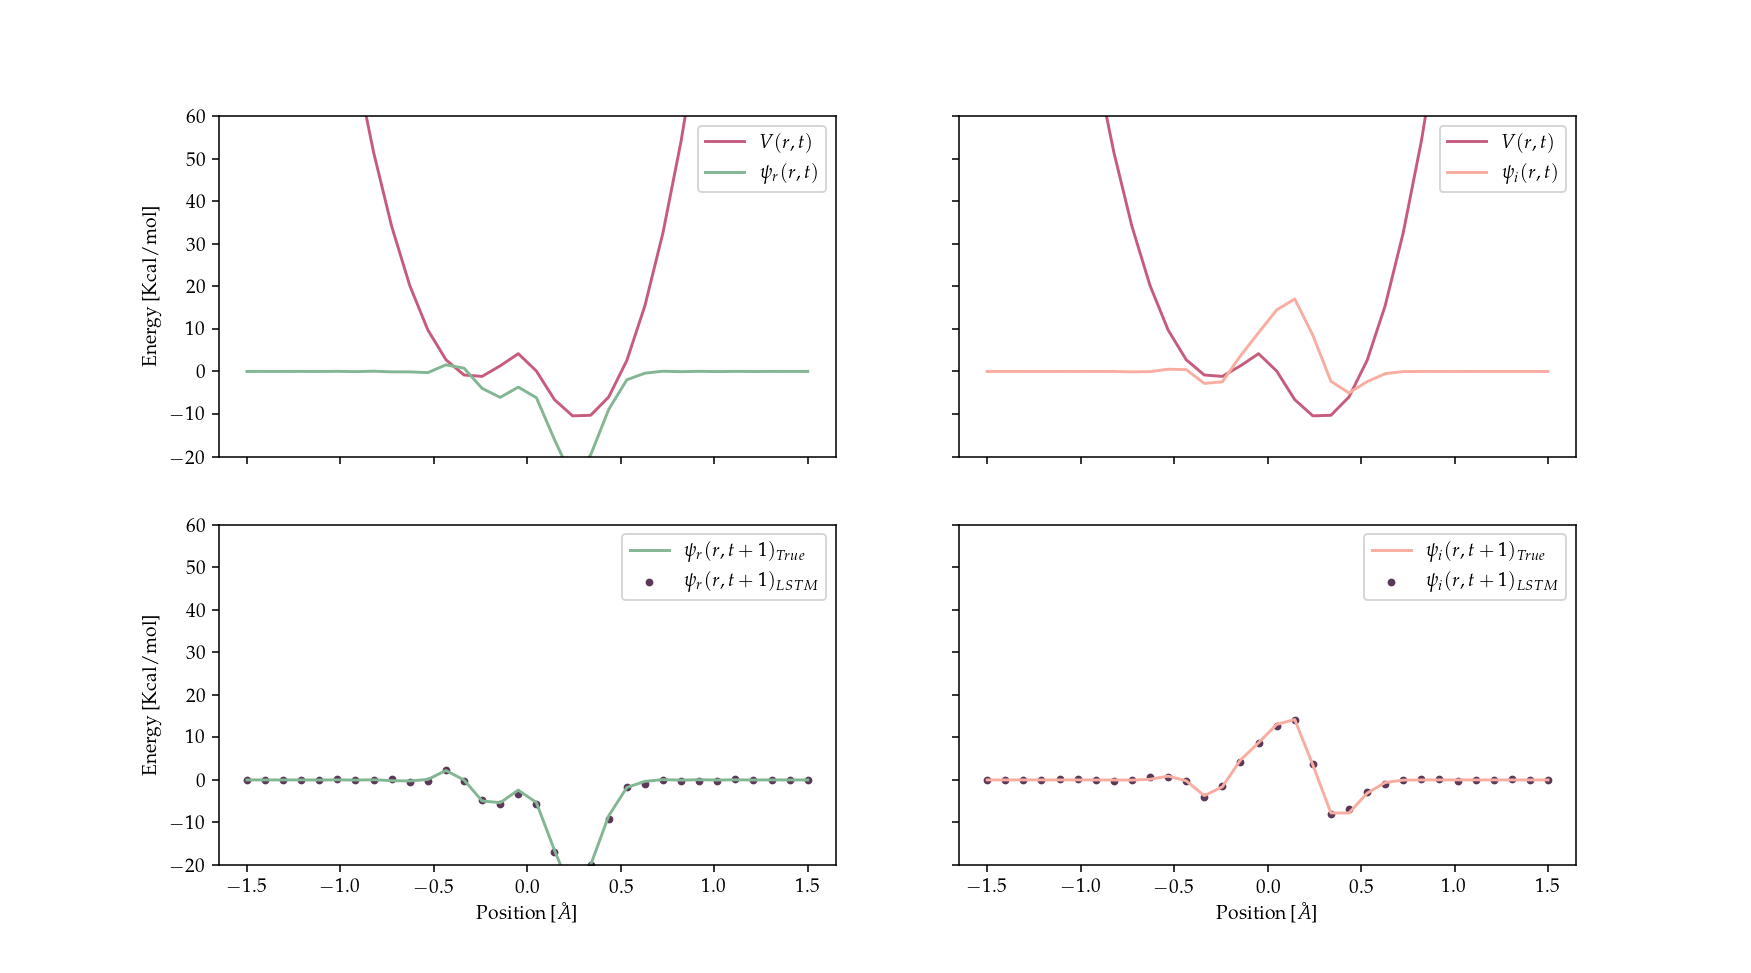

In [294]:
fig, axs = plt.subplots(2,2)

# Lenght: au -> Angstroms
axs[0,0].plot(r_n, Pote*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
axs[0,0].plot(r_n, In_real_vis*20, label="$\psi_{r}(r, t)$", color=color[0])  # Escaled


axs[0,1].plot(r_n, Pote*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
axs[0,1].plot(r_n, In_imag_vis*20, label="$\psi_{i}(r, t)$", color = color[1])  # Escaled

#axs[0].plot(r_n, Pote_next*(1/1.5936e-3), "-", label="V(r,t)", color=color[3])
axs[1,0].plot(r_n, Ou_real_vis*20, label="$\psi_{r}(r, t+1)_{True}$", color=color[0])  # Escaled
axs[1,0].scatter(r_n, Pred_real_vis*20, label="$\psi_{r}(r, t+1)_{LSTM}$", color=color[4], marker='.')  # Escaled
 

axs[1,1].plot(r_n, Ou_imag_vis*20, label="$\psi_{i}(r, t+1)_{True}$", color = color[1])  # Escaled
axs[1,1].scatter(r_n, Pred_imag_vis*20, label="$\psi_{i}(r, t+1)_{LSTM}$", color = color[4], marker='.')  # Escaled

for axr1 in axs:
    for axr11 in axr1:
        axr11.set_ylim([-20, 60])
        axr11.legend()
        axr11.set(xlabel='Position [$\AA$]', ylabel='Energy [Kcal/mol]')
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
 

plt.gcf().set_size_inches(9, 5)
plt.legend()    
plt.show()

## Predictions density

In [295]:
#------------- t=0
In_real_vis0 = Entrada[2,0,0:32].detach().numpy()
In_imag_vis0 = Entrada[2,0,32:64].detach().numpy()
In_dens0 = (np.abs(np.vectorize(complex)(In_real_vis0,In_imag_vis0)))**2

Pote0 = Entrada[2,0,64:96].detach().numpy()


#------------ t=40 fs
Ou_real_vis0 = Salida[2,40,0:32].detach().numpy()
Ou_imag_vis0 = Salida[2,40,32:64].detach().numpy()
Ou_dens0 = (np.abs(np.vectorize(complex)(Ou_real_vis0,Ou_imag_vis0)))**2
      
Pred_real_vis0 = Prediccion[2,40,0:32].detach().numpy()
Pred_imag_vis0 = Prediccion[2,40,32:64].detach().numpy()
Pred_dens0 = (np.abs(np.vectorize(complex)(Pred_real_vis0,Pred_imag_vis0)))**2

#-------------- t=80 fs
In_real_vis1 = Entrada[2,80,0:32].detach().numpy()
In_imag_vis1 = Entrada[2,80,32:64].detach().numpy()
Pote1 = Entrada[2,80,64:96].detach().numpy()

Ou_real_vis1 = Salida[2,80,0:32].detach().numpy()
Ou_imag_vis1 = Salida[2,80,32:64].detach().numpy()
Ou_dens1 = (np.abs(np.vectorize(complex)(Ou_real_vis1,Ou_imag_vis1)))**2

Pred_real_vis1 = Prediccion[2,80,0:32].detach().numpy()
Pred_imag_vis1 = Prediccion[2,80,32:64].detach().numpy()
Pred_dens1 = (np.abs(np.vectorize(complex)(Pred_real_vis1,Pred_imag_vis1)))**2

#-------------- t=120 fs
In_real_vis2 = Entrada[2,120,0:32].detach().numpy()
In_imag_vis2 = Entrada[2,120,32:64].detach().numpy()
Pote2 = Entrada[2,120,64:96].detach().numpy()

Ou_real_vis2 = Salida[2,120,0:32].detach().numpy()
Ou_imag_vis2 = Salida[2,120,32:64].detach().numpy()
Ou_dens2 = (np.abs(np.vectorize(complex)(Ou_real_vis2,Ou_imag_vis2)))**2

Pred_real_vis2 = Prediccion[2,120,0:32].detach().numpy()
Pred_imag_vis2 = Prediccion[2,120,32:64].detach().numpy()
Pred_dens2 = (np.abs(np.vectorize(complex)(Pred_real_vis2,Pred_imag_vis2)))**2

#-------------- t=160 fs
In_real_vis3 = Entrada[2,160,0:32].detach().numpy()
In_imag_vis3 = Entrada[2,160,32:64].detach().numpy()
Pote3 = Entrada[2,160,64:96].detach().numpy()

Ou_real_vis3 = Salida[2,160,0:32].detach().numpy()
Ou_imag_vis3 = Salida[2,160,32:64].detach().numpy()
Ou_dens3 = (np.abs(np.vectorize(complex)(Ou_real_vis3,Ou_imag_vis3)))**2

Pred_real_vis3 = Prediccion[2,160,0:32].detach().numpy()
Pred_imag_vis3 = Prediccion[2,160,32:64].detach().numpy()
Pred_dens3 = (np.abs(np.vectorize(complex)(Pred_real_vis3,Pred_imag_vis3)))**2

#-------------- t=200 fs
In_real_vis4 = Entrada[2,199,0:32].detach().numpy()
In_imag_vis4 = Entrada[2,199,32:64].detach().numpy()
Pote4 = Entrada[2,199,64:96].detach().numpy()

Ou_real_vis4 = Salida[2,199,0:32].detach().numpy()
Ou_imag_vis4 = Salida[2,199,32:64].detach().numpy()
Ou_dens4 = (np.abs(np.vectorize(complex)(Ou_real_vis4,Ou_imag_vis4)))**2

Pred_real_vis4 = Prediccion[2,199,0:32].detach().numpy()
Pred_imag_vis4 = Prediccion[2,199,32:64].detach().numpy()
Pred_dens4 = (np.abs(np.vectorize(complex)(Pred_real_vis4,Pred_imag_vis4)))**2



<IPython.core.display.Javascript object>


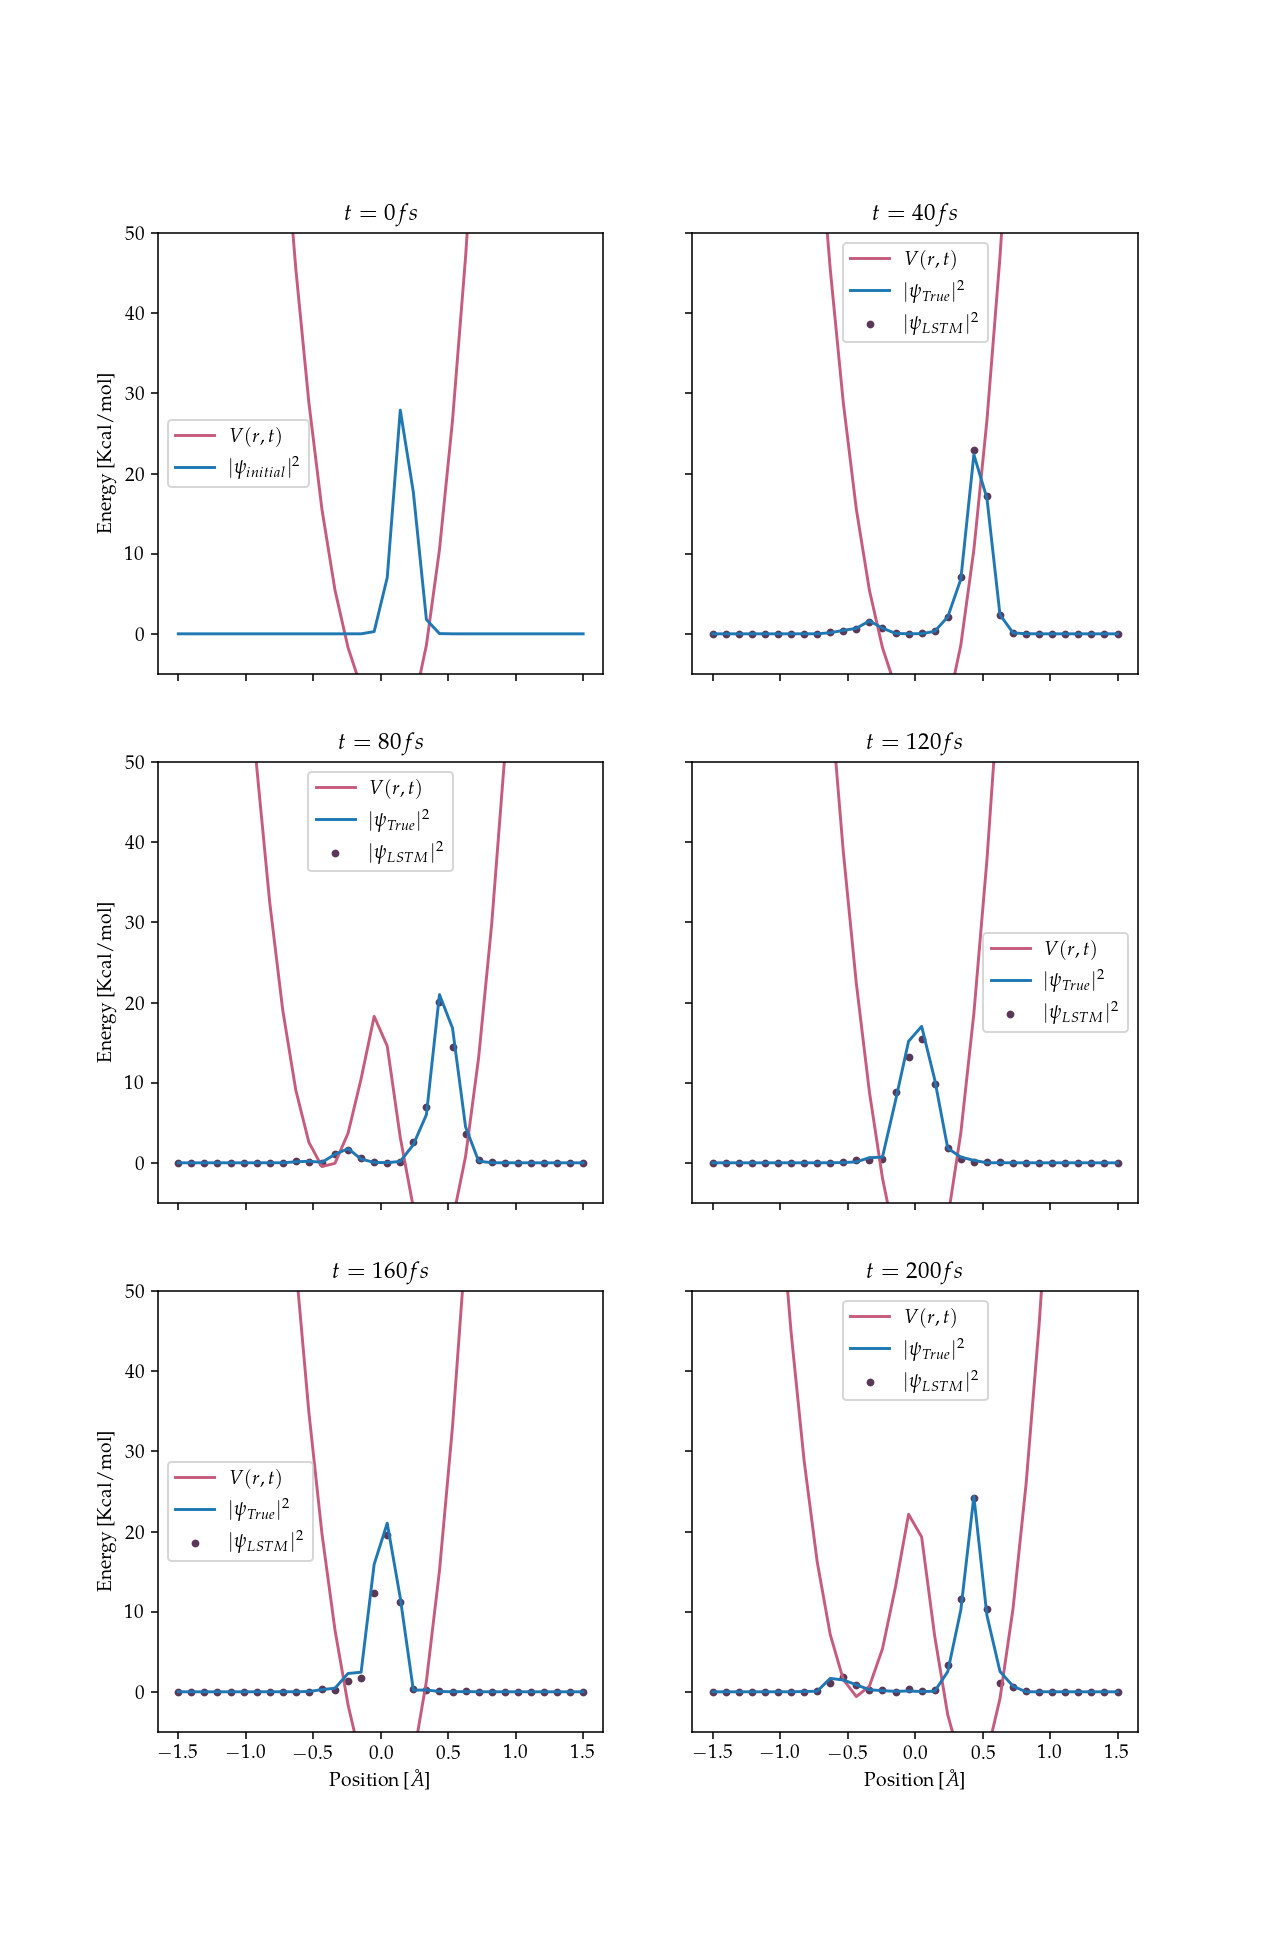

In [296]:
fig, axs = plt.subplots(3,2)


    
# Time: fs -> au, Lenght: au -> Angstroms, Energy: au -> kcal/mol
axs[0,0].plot(r_n, Pote0*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
axs[0,0].plot(r_n, In_dens0*10, label="$|\psi_{initial}|^{2}$")
axs[0,0].set_title("$t=0 fs$")


axs[0,1].plot(r_n, Pote0*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
axs[0,1].scatter(r_n, Pred_dens0*10, label="$|\psi_{LSTM}|^{2}$", color=color[4], marker='.')
axs[0,1].plot(r_n, Ou_dens0*10, label="$|\psi_{True}|^{2}$")
axs[0,1].set_title("$t=40 fs$")

axs[1,0].plot(r_n, Pote1*(1/1.5936e-3), "-", label="$V(r, t)$", color=color[3])
axs[1,0].scatter(r_n, Pred_dens1*10, label="$|\psi_{LSTM}|^{2}$", color=color[4], marker='.')
axs[1,0].plot(r_n, Ou_dens1*10, label="$|\psi_{True}|^{2}$")
axs[1,0].set_title("$t=80 fs$")

axs[1,1].plot(r_n, Pote2*(1/1.5936e-3), "-", label="$V(r, t)$", color=color[3])
axs[1,1].scatter(r_n, Pred_dens2*(10), label="$|\psi_{LSTM}|^{2}$", color=color[4], marker='.')
axs[1,1].plot(r_n, Ou_dens2*10, label="$|\psi_{True}|^{2}$")
axs[1,1].set_title("$t=120 fs$")

axs[2,0].plot(r_n, Pote3*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
axs[2,0].scatter(r_n, Pred_dens3*(10), label="$|\psi_{LSTM}|^{2}$", color=color[4], marker='.')
axs[2,0].plot(r_n, Ou_dens3*10, label="$|\psi_{True}|^{2}$")
axs[2,0].set_title("$t=160 fs$")

axs[2,1].plot(r_n, Pote4*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
axs[2,1].scatter(r_n, Pred_dens4*(10), label="$|\psi_{LSTM}|^{2}$", color=color[4], marker='.')
axs[2,1].plot(r_n, Ou_dens4*10, label="$|\psi_{True}|^{2}$")
axs[2,1].set_title("$t=200 fs$")







for axr1 in axs:
    for axr11 in axr1:
        axr11.set_ylim([-5, 50])
        axr11.legend()
        axr11.set(xlabel='Position [$\AA$]', ylabel='Energy [Kcal/mol]')
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
plt.gcf().set_size_inches(6.5, 10)
plt.legend()    
plt.show()

### Saving data to animation

In [312]:
Entrada[:,:,64:96].shape

torch.Size([10, 200, 32])

In [315]:
newPred = Prediccion.numpy()  # By model real & imag part
newSal = Salida.numpy()  # Analitical real & imag part
Poten = Entrada[:,:,64:96].numpy()  # Potential

In [318]:
with open(os.path.join('../Animacion/ModelLSTM/prediccion.npy'), 'wb') as f:
    np.save(f, newPred)

In [319]:
with open(os.path.join('../Animacion/ModelLSTM/salida.npy'), 'wb') as f:
    np.save(f, newSal)

In [320]:
with open(os.path.join('../Animacion/ModelLSTM/potencial.npy'), 'wb') as f:
    np.save(f, Poten)

## New trajectory

Para asegurar que la red funciona xd

In [129]:
path_test = '../../NewTrajectories/data'  # Directory where are a total new trajectory
seq_len = 200  # How many time stamps

In [130]:
dataset_newTest = Propagator_Dataset(data=path_test, targets=path_test, transform=True, sequence_len=seq_len, total_data = 1*200)

In [131]:
newTraj = DataLoader(dataset_newTest)

In [132]:
for X,y in newTraj:
    X, y = X.to(device), y.to(device)
    
    Entrada = X
    
    Salida = y
    with torch.inference_mode():
        Prediccion = model(X.float())
    break

In [133]:
print(Entrada.shape)
print(Prediccion.shape)
print(Salida.shape)

torch.Size([1, 200, 96])
torch.Size([1, 200, 64])
torch.Size([1, 200, 64])


In [134]:
r_n = np.linspace(-1.5,1.5,32)

time = int(160)  # from 0 to 199 fs

In_real_vis = Entrada[0,time,0:32].detach().numpy()
In_imag_vis = Entrada[0,time,32:64].detach().numpy()
Pote = Entrada[0,time,64:96].detach().numpy()

Ou_real_vis = Salida[0,time,0:32].detach().numpy()
Ou_imag_vis = Salida[0,time,32:64].detach().numpy()
Pote_next = Entrada[0,time+1,64:96].detach().numpy()

Pred_real_vis = Prediccion[0,time,0:32].detach().numpy()
Pred_imag_vis = Prediccion[0,time,32:64].detach().numpy()

<IPython.core.display.Javascript object>


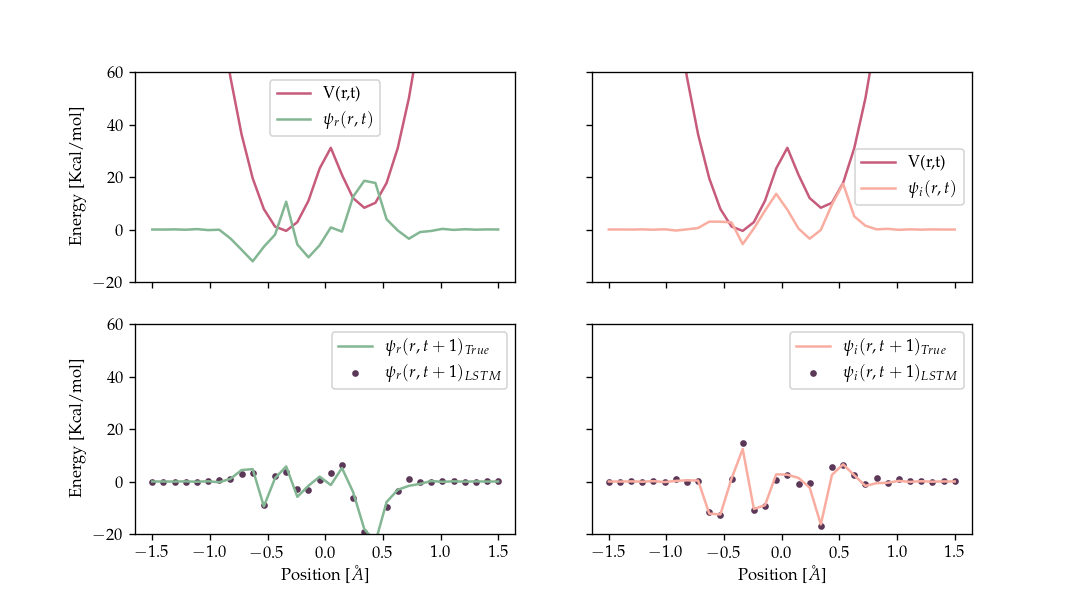

In [135]:
fig, axs = plt.subplots(2,2)

# Lenght: au -> Angstroms
axs[0,0].plot(r_n, Pote*(1/1.5936e-3), "-", label="V(r,t)", color=color[3])
axs[0,0].plot(r_n, In_real_vis*20, label="$\psi_{r}(r, t)$", color=color[0])  # Escaled


axs[0,1].plot(r_n, Pote*(1/1.5936e-3), "-", label="V(r,t)", color=color[3])
axs[0,1].plot(r_n, In_imag_vis*20, label="$\psi_{i}(r, t)$", color = color[1])  # Escaled

#axs[0].plot(r_n, Pote_next*(1/1.5936e-3), "-", label="V(r,t)", color=color[3])
axs[1,0].plot(r_n, Ou_real_vis*20, label="$\psi_{r}(r, t+1)_{True}$", color=color[0])  # Escaled
axs[1,0].scatter(r_n, Pred_real_vis*20, label="$\psi_{r}(r, t+1)_{LSTM}$", color=color[4], marker='.')  # Escaled


axs[1,1].plot(r_n, Ou_imag_vis*20, label="$\psi_{i}(r, t+1)_{True}$", color = color[1])  # Escaled
axs[1,1].scatter(r_n, Pred_imag_vis*20, label="$\psi_{i}(r, t+1)_{LSTM}$", color = color[4], marker='.')  # Escaled

for axr1 in axs:
    for axr11 in axr1:
        axr11.set_ylim([-20, 60])
        axr11.legend()
        axr11.set(xlabel='Position [$\AA$]', ylabel='Energy [Kcal/mol]')
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
plt.gcf().set_size_inches(9, 5)
plt.legend()    
plt.show()

yes it works